In [1]:
# --- Standard Library & General Science ---
import warnings
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import eigh
from scipy.optimize import minimize
from scipy.sparse import dok_matrix, csr_matrix
from scipy.sparse.linalg import eigsh
from IPython.display import display

# --- Graph Theory & Visualization ---
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

# --- Quantum Chemistry & Simulation (Non-Qiskit) ---
import pyscf
import pyscf.cc
import pyscf.mcscf
from pyscf import ao2mo, gto, mcscf, scf

# --- Qiskit: Core & Circuit ---
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import EfficientSU2, TwoLocal, efficient_su2
from qiskit.circuit.library import (
    RXXGate, RYYGate, RZZGate, RZGate,
    QAOAAnsatz, PauliEvolutionGate
)
from qiskit.synthesis import LieTrotter
from qiskit.quantum_info import SparsePauliOp, Statevector

# --- Qiskit: Quantum Information ---
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix, Operator

# --- Qiskit: Transpiler & Providers ---
from qiskit.transpiler import Layout, CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import AerSimulator

# --- Qiskit: Primitives & Runtime ---
from qiskit.primitives import StatevectorEstimator
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Session,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)
from qiskit_ibm_runtime.debug_tools import Neat

# --- Qiskit: Visualization ---
from qiskit.visualization import plot_histogram
# Qiskit Nature
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel
from qiskit_nature.second_q.problems import LatticeModelProblem
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.hamiltonians.lattices import BoundaryCondition, LineLattice
from qiskit_nature.second_q.circuit.library import HartreeFock, UCC
from qiskit_nature.second_q.operators import FermionicOp

# Qiskit Algorithms & Solvers
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import NumPyMinimumEigensolver

# Qiskit Primitives & Simulator
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_aer import AerSimulator

In [2]:
def build_fermi_hubbard_4x1_op(t, U):
    num_sites = 4
    num_spin_orbitals = 2 * num_sites
    terms = {}

    def up_index(site): return site
    def down_index(site): return site + num_sites

    edges = [(0, 1), (1, 2), (2, 3)]

    # Hopping 
    for (i, j) in edges:
        # Spin UP
        p, q = up_index(i), up_index(j)
        terms[f"+_{p} -_{q}"] = terms.get(f"+_{p} -_{q}", 0.0) - t
        terms[f"+_{q} -_{p}"] = terms.get(f"+_{q} -_{p}", 0.0) - t

        # Spin DOWN
        p, q = down_index(i), down_index(j)
        terms[f"+_{p} -_{q}"] = terms.get(f"+_{p} -_{q}", 0.0) - t
        terms[f"+_{q} -_{p}"] = terms.get(f"+_{q} -_{p}", 0.0) - t

    # Interaction
    for i in range(num_sites):
        u_idx, d_idx = up_index(i), down_index(i)
        op_str = f"+_{u_idx} -_{u_idx} +_{d_idx} -_{d_idx}"
        terms[op_str] = terms.get(op_str, 0.0) + U

    return FermionicOp(terms, num_spin_orbitals=num_spin_orbitals)

In [3]:


def apply_hop(qc, theta, q1, q2):
    qc.rxx(theta, q1, q2)
    qc.ryy(theta, q1, q2)

def create_4x1_hybrid_ansatz(reps=4):
    num_sites = 4
    num_qubits = 8
    qc = QuantumCircuit(num_qubits)

    qc.x([0, 2, 5, 7])
    qc.barrier()

    params_per_rep = 8 + 4 + 6
    total_params = reps * params_per_rep
    theta = ParameterVector('θ', length=total_params)
    p_idx = 0

    edges = [(0, 1), (1, 2), (2, 3)]

    for layer in range(reps):
        for q in range(num_qubits):
            qc.rz(theta[p_idx], q); p_idx += 1

        for i in range(num_sites):
            qc.rzz(theta[p_idx], i, i + 4); p_idx += 1

        for (i, j) in edges:
            apply_hop(qc, theta[p_idx], i, j); p_idx += 1

        for (i, j) in edges:
            apply_hop(qc, theta[p_idx], i + 4, j + 4); p_idx += 1

        qc.barrier()

    return qc

In [4]:
def solve_exact_diagonalization_4x1(qubit_op, mapper):
    H_matrix = qubit_op.to_matrix()

    num_op_ferm = FermionicOp({f"+_{i} -_{i}": 1.0 for i in range(8)}, num_spin_orbitals=8)
    num_op_diag = np.diag(mapper.map(num_op_ferm).to_matrix()).real

    penalty = 100.0
    H_with_penalty = H_matrix + penalty * np.diag((num_op_diag - 4.0)**2)

    evals, _ = eigh(H_with_penalty)

    valid_evals = evals[evals < 50.0]

    return valid_evals[0], valid_evals[1]

In [5]:
def solve_vqe_vqd_4x1(hamiltonian, ansatz, prev_params_gs=None):
    estimator = Estimator()
    num_params = ansatz.num_parameters

    def cost_gs(params):
        job = estimator.run([(ansatz, hamiltonian, params)])
        return job.result()[0].data.evs

    if prev_params_gs is not None:
        x0_gs = prev_params_gs + np.random.uniform(-0.02, 0.02, num_params)
    else:
        x0_gs = np.random.uniform(-0.02, 0.02, num_params)

    optimizer = SLSQP(maxiter=5000, ftol=1e-06)
    res_gs = optimizer.minimize(fun=cost_gs, x0=x0_gs)
    E_gs_vqe = res_gs.fun

    qc_gs = ansatz.assign_parameters(res_gs.x)
    sv_gs = Statevector(qc_gs)

    BETA = 4.0

    def cost_es(params):
        E = estimator.run([(ansatz, hamiltonian, params)]).result()[0].data.evs

        qc_curr = ansatz.assign_parameters(params)
        sv_curr = Statevector(qc_curr)
        overlap = np.abs(sv_gs.inner(sv_curr))**2

        return E + BETA * overlap

    x0_es = res_gs.x + np.random.uniform(0.1, 0.3, num_params)

    res_es = optimizer.minimize(fun=cost_es, x0=x0_es)

    qc_es = ansatz.assign_parameters(res_es.x)
    sv_es = Statevector(qc_es)
    final_overlap = np.abs(sv_gs.inner(sv_es))**2
    E_es_vqd = res_es.fun - BETA * final_overlap

    return E_gs_vqe, E_es_vqd, res_gs.x

--- FERMI-HUBBARD 4x1 (1D CHAIN) ANALYSIS ---
U/t   | Ex GS        VQE GS       | Ex 1st       VQD 1st      | Err 1st   
--------------------------------------------------------------------------------
0.0   | -4.472136    -4.472135    | -3.236068    -3.236067    | 0.000001  
1.0   | -3.575366    -3.574993    | -2.596722    -2.588180    | 0.008542  
2.0   | -2.875943    -2.873340    | -2.087154    -2.081607    | 0.005547  
3.0   | -2.347427    -2.347013    | -1.700543    -1.676702    | 0.023841  
4.0   | -1.953145    -1.952517    | -1.412899    -1.406344    | 0.006554  


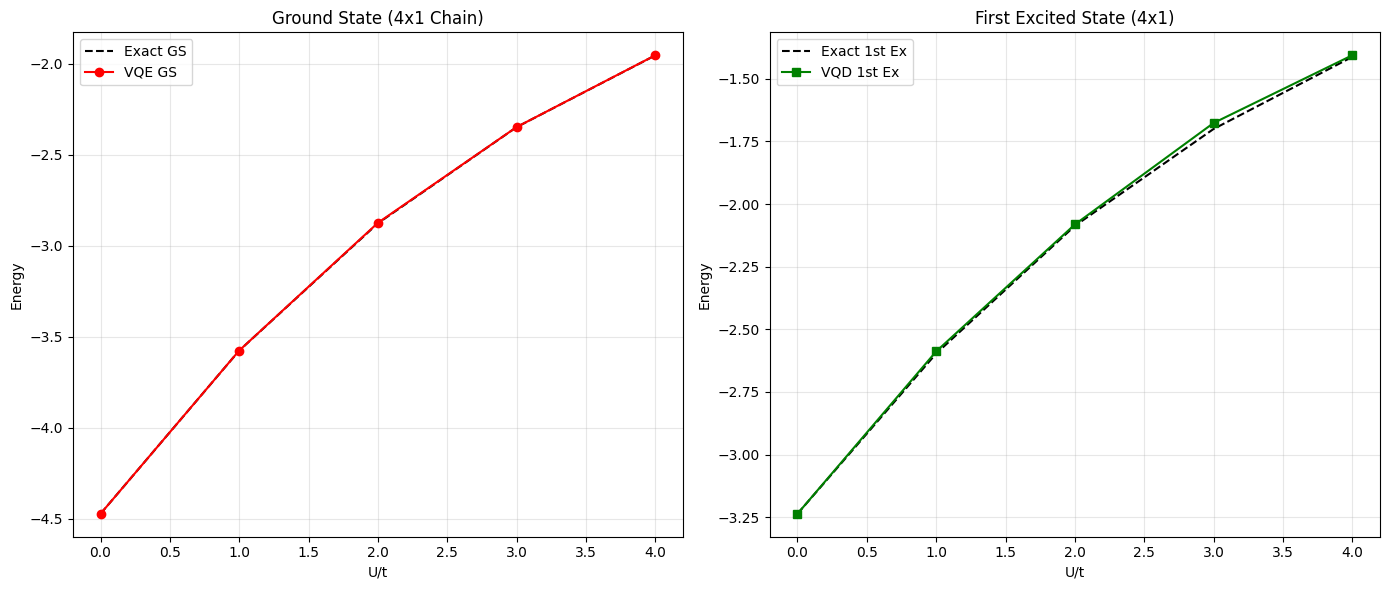

In [6]:
def main():
    t = 1.0
    U_values = [0.0, 1.0, 2.0, 3.0, 4.0]
    reps = 4

    mapper = JordanWignerMapper()

    exact_gs, exact_es1 = [], []
    vqe_gs, vqd_es1 = [], []

    prev_params = None

    print(f"--- FERMI-HUBBARD 4x1 (1D CHAIN) ANALYSIS ---")
    print(f"{'U/t':<5} | {'Ex GS':<12} {'VQE GS':<12} | {'Ex 1st':<12} {'VQD 1st':<12} | {'Err 1st':<10}")
    print("-" * 80)

    for U in U_values:
        ferm_op = build_fermi_hubbard_4x1_op(t, U)
        qubit_op = mapper.map(ferm_op)
        ansatz = create_4x1_hybrid_ansatz(reps=reps)

        ex_g, ex_e1 = solve_exact_diagonalization_4x1(qubit_op, mapper)
        exact_gs.append(ex_g)
        exact_es1.append(ex_e1)

        v_g, v_e1, opt_params = solve_vqe_vqd_4x1(qubit_op, ansatz, prev_params)
        vqe_gs.append(v_g)
        vqd_es1.append(v_e1)

        prev_params = opt_params

        err_e1 = abs(ex_e1 - v_e1)
        print(f"{U:<5.1f} | {ex_g:<12.6f} {v_g:<12.6f} | {ex_e1:<12.6f} {v_e1:<12.6f} | {err_e1:<10.6f}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.plot(U_values, exact_gs, 'k--', label='Exact GS')
    ax1.plot(U_values, vqe_gs, 'r-o', label='VQE GS')

    ax1.set_title("Ground State (4x1 Chain)")
    ax1.set_xlabel("U/t"); ax1.set_ylabel("Energy")
    ax1.legend(); ax1.grid(True, alpha=0.3)

    ax2.plot(U_values, exact_es1, 'k--', label='Exact 1st Ex')
    ax2.plot(U_values, vqd_es1, 'g-s', label='VQD 1st Ex')

    ax2.set_title("First Excited State (4x1)")
    ax2.set_xlabel("U/t"); ax2.set_ylabel("Energy")
    ax2.legend(); ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()